## Name: Karma Tarap
### CSCI E-89C Deep Reinforcement Learning  
### Part II of Assignment 7

# Problem 1 (15 points)

In this problem we again consider patients with end-stage liver disease (ESLD). We assume that patient's health condition is fully characterized by the Model for End-stage Liver Disease (MELD) score (Jae-Hyeon Ahn and John Hornberger, Involving patients in the cadaveric kidney transplant allocation process: a decision-theoretic perspective. Manage Sci. 1996;42(5):629–41).

The MELD score ranges from 6 to 40 and is derived based on the probability of survival at 3 months for patients with ESLD. Data in ESLD is usually sparse and often aggregated into Stages. We assume that there are 18 stages based on the ESLD: Stage 1, Stage2, ..., Stage 18. The time step is 1 year and the actions in Stages 1 through 18 are "wait" (denoted by 0) and "transplant" (denoted by 1). 

We assume that the Markov property holds. There are two additional states of the Markov Decision Process: "Posttransplant Life" (denoted by 19) and "Death" (which is denoted by 20 and combines so caled "Pretransplant Death" and "Posttransplant Death"). The only action availible in state "Posttransplant Life" is "wait" and "Death" is the terminal state with no actions. Assume that the length of an episode is T=50, unless it terminates earlier due to the transition to the absorbing state "Death."

We do not know the transition probabilities, but if a patient selects "wait," the possible transitions are   
1) Stage 1->Stage 1, Stage 1->Stage 2, Stage 1->Death  
2) For k in {2,3,4,...17}, Stage k->Stage (k-1), Stage k->Stage k, Stage k->Stage (k+1), Stage k->Death    
3) Stage 18->Stage 17, Stage 18->Stage 18, Stage 18->Death    

If a patient selects "transplant" at Stage k, k=1,2,...,18, the only possible transition is  
4) Stage k->"Posttransplant Life"

Finally, there are two more possible transitions"  
5) "Posttransplant Life"->"Posttransplant Life" and "Posttransplant Life"->"Death"  


The patient gets reward 1 in all states "Stage k" (k=1,2,...,18) and reward 0.2 in the "Posttransplant Life" state - assume that the patient gets these rewards on "exit" from the states, i.e. after we observe the corresponding stage. We assume the discounting parameter $\gamma=0.97$, one of the most common discounting rate used in medical decision making (Gold MR, Siegel JE, Russell LB, Weinstein MC. Cost-Effectiveness in Health and Medicine. Oxford University Press; New York: 1996).


Please consider statistics on 8,000 patients with ESLD saved in the 'ESLD_statistics.csv' file. Eeach row represents an episode (i.e. one patient) and the columns are the sequences of the patients' states and actions. This data were generated under the following policy:

$\pi(1|k)=0.02$ for $k\in\{1,2,3,4,5,6,7,8,9,10,11,12,13\}$;   
$\pi(1|14)=0.05$;   
$\pi(1|15)=0.10$;   
$\pi(1|16)=0.20$;   
$\pi(1|17)=0.40$;  
$\pi(1|18)=0.60$;  

which means that, for example, 5% of paients at stage 14 received a transplant.   
     
     
Let's approximate the state-values as follows:

$$v_\pi(s)\approx\hat{v}(s,{\bf w}) = \sum_{k=1}^{18} \left(w_1+w_2 k+w_3 k^2\right)\cdot \mathbb{1}_{(s=\text{"Stage }k\text{"})}+w_4\cdot \mathbb{1}_{(s=\text{"Posttransplant Life"})},$$

where ${\bf w}=(w_1,w_2,w_3,w_4)^T$. Please notice that $\hat{v}(\text{"Death"},{\bf w})=0$. 


Please initialize all weights at $0$ and run the semi-gradient 1-step TD algorithm for estimating $v_\pi$ (experiment with the choice of the learning rate $\alpha$). Report obtained weights $w_1,w_2, w_3,w_4$ and also estimates of the state-value function $v_\pi(s)$ for all states.

In [1]:
import random
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
np.set_printoptions(precision=3)

In [2]:
# Read in data and take a peek
elsd = pd.read_csv("ESLD_statistics.csv")
elsd.head()

,S0,A0,S1,A1,S2,A2,S3,A3,S4,A4,...,A45,S46,A46,S47,A47,S48,A48,S49,A49,S50
0,12,0,12,0,13,0,13,0,20,0,...,0,20,0,20,0,20,0,20,0,20
1,3,0,3,0,3,0,3,0,3,0,...,0,20,0,20,0,20,0,20,0,20
2,16,0,16,0,16,1,19,0,19,0,...,0,20,0,20,0,20,0,20,0,20
3,13,0,13,0,13,0,13,0,14,0,...,0,20,0,20,0,20,0,20,0,20
4,4,0,4,0,4,0,20,0,20,0,...,0,20,0,20,0,20,0,20,0,20


In [3]:
def π(state, action):
    """
    Mapping of state and action to probability of action given state
    for policy. Transition probabilities taken from notebook.
    
    Args:
        state: current state
        action: current action
        
    Returns:
        Probability of action given state.
    """
    # placeholder probabilities of 0 added for post-transplant and death
    transplant_pr = [.02 for i in range(13)] + [.05, .1, .2, .4, .6, 0., 0.]
    return transplant_pr[state-1] if action == 1 else 1-transplant_pr[state-1]


assert π(13,1)  == 0.02
assert π(14,1)  == 0.05
assert π(15,1)  == 0.10
assert π(16,1)  == 0.20
assert π(17,1)  == 0.40
assert π(18,1)  == 0.60
assert π(13,0)  == 1-0.02
assert π(14,0)  == 1-0.05
assert π(15,0)  == 1-0.10
assert π(16,0)  == 1-0.20
assert π(17,0)  == 1-0.40
assert π(18,0)  == 1-0.60

In [4]:
def get_episode(df, k):
    """
    Return States, Actions, Rewards from episode in a dataframe
    
    Args:
        df: dataframe
        k: int: kth episode  
        
    Returns:
        list: States, Actions, Rewards
    """
    states = df.values[k,0:-1:2]
    actions = df.values[k,1::2]
    rewards = (states <= 18)*1 + (states == 19)*0.2
    return [states, actions, rewards]

$$v_\pi(s)\approx\hat{v}(s,{\bf w}) = \sum_{k=1}^{18} \left(w_1+w_2 k+w_3 k^2\right)\cdot \mathbb{1}_{(s=\text{"Stage }k\text{"})}+w_4\cdot \mathbb{1}_{(s=\text{"Posttransplant Life"})},$$

In [5]:
def v_hat(state, w):
    """
    Returns Approximation of state value under policy π
    
    Args:
        state: int: 
        w: numpy array: weights
        
    Returns:
        int:
    """
    k = state
    return (w[0] + w[1]*k + w[2]*k**2) *(k<19) + (w[3]*(k==19))

w = np.ones(4)
for s in range(1,21):
    print("state:", s, ", v_hat:",v_hat(s,w))
    
assert(v_hat(19, w)) == 1 #post transplant life
assert(v_hat(20, w)) == 0 #death

state: 1 , v_hat: 3.0
state: 2 , v_hat: 7.0
state: 3 , v_hat: 13.0
state: 4 , v_hat: 21.0
state: 5 , v_hat: 31.0
state: 6 , v_hat: 43.0
state: 7 , v_hat: 57.0
state: 8 , v_hat: 73.0
state: 9 , v_hat: 91.0
state: 10 , v_hat: 111.0
state: 11 , v_hat: 133.0
state: 12 , v_hat: 157.0
state: 13 , v_hat: 183.0
state: 14 , v_hat: 211.0
state: 15 , v_hat: 241.0
state: 16 , v_hat: 273.0
state: 17 , v_hat: 307.0
state: 18 , v_hat: 343.0
state: 19 , v_hat: 1.0
state: 20 , v_hat: 0.0


In [6]:
def grad(state): 
    """
    Returns vector of analytical gradients of function v_hat
    
    Args:
        State: int
    Returns:
        numpy array: gradients
    """
    k = state
    return np.array([k<19, k*(k<19), k**2*(k<19), k==19])

In [7]:
for s in range(1,21):
    print("state:", s, ", gradient:",grad(s))

state: 1 , gradient: [1 1 1 0]
state: 2 , gradient: [1 2 4 0]
state: 3 , gradient: [1 3 9 0]
state: 4 , gradient: [ 1  4 16  0]
state: 5 , gradient: [ 1  5 25  0]
state: 6 , gradient: [ 1  6 36  0]
state: 7 , gradient: [ 1  7 49  0]
state: 8 , gradient: [ 1  8 64  0]
state: 9 , gradient: [ 1  9 81  0]
state: 10 , gradient: [  1  10 100   0]
state: 11 , gradient: [  1  11 121   0]
state: 12 , gradient: [  1  12 144   0]
state: 13 , gradient: [  1  13 169   0]
state: 14 , gradient: [  1  14 196   0]
state: 15 , gradient: [  1  15 225   0]
state: 16 , gradient: [  1  16 256   0]
state: 17 , gradient: [  1  17 289   0]
state: 18 , gradient: [  1  18 324   0]
state: 19 , gradient: [0 0 0 1]
state: 20 , gradient: [0 0 0 0]


In [8]:
def semi_gradient_td(df=elsd, gamma=0.97, T=49, alpha=.0001):
    V = np.zeros(20)
    w = np.zeros(4)
    w_history = []
    num_episodes = df.shape[0]-1
    n = 1
    a = alpha
    for _ in range(num_episodes):
        k = random.randint(0, num_episodes)
        #sample episodes with replacement
        episode = get_episode(df, k)

        for t in range(0,T):
            n += t
            S = episode[0][t]
            S1 = episode[0][t+1]
            R = episode[2][t]

            if alpha is None:
                alpha = 1./(n)
                
            #print(S, ">>", S1, ": R=", R, w, v_hat(S, w), v_hat(S1, w), grad(S))    
            w = w + alpha *((R + gamma*v_hat(S1, w)) - v_hat(S, w)) * grad(S)
            
            # death is terminal state
            if S == 20:
                break             
        w_history.append(w.copy())
        
    return [v_hat(s,w) for s in range(1,21)], w, np.vstack(w_history)

V, w, hist = semi_gradient_td()

[1.0295512876851571, 1.6899090080862031, 2.2598666323014487, 2.7394241603308935, 3.128581592174539, 3.4273389278323827, 3.635696167304427, 3.75365331059067, 3.7812103576911125, 3.7183673086057567, 3.5651241633345983, 3.32148092187764, 2.987437584234881, 2.5629941504063236, 2.0481506203919633, 1.4429069941918033, 0.7472632718058421, -0.0387805467659188, 0.037187303847589545, 0.0]


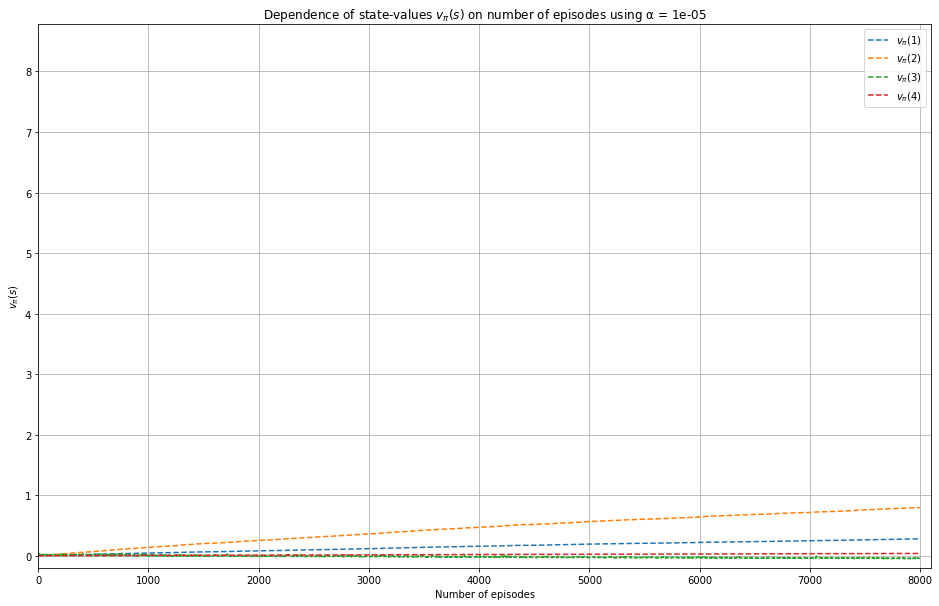

In [9]:
def plot_func(alpha=.1,f=semi_gradient_td):
    contents = f(df=elsd, gamma=0.97, T=49, alpha=alpha)
    V, v_hist = contents[0], contents[-1]
    print(V)
    plt.figure(figsize=(16,10))
    vplot = plt.plot((v_hist), linestyle='--', marker=None, label="r")
    plt.xlabel("Number of episodes")
    plt.ylabel("$v_\pi(s)$")
    plt.title(f'Dependence of state-values $v_\pi(s)$ on number of episodes using α = {alpha}')
    plt.ylim(-0.2, max(V)+5)
    plt.xlim(0,v_hist.shape[0]+100)
    plt.grid(True)
    plt.legend(vplot, [f'$v_\pi({i})$' for i in range(1,21)],loc = 'upper right');
    plt.show()
    
plot_func(alpha=.00001)

I tried a whole range of alphas, unfortunately I could not get the weights to stop blowing up, without using very small alpha that gave the wrong state values as it converges too slowly. Using a dynamic alpha also did not seem to help.

# Problem 2 (5 points)

Please initialize all state-values at $0$ and run the tabular 1-step TD method for estimating $v_\pi$ (again, please experiment with the choice of $\alpha$). Report the estimates of the state-value function $v_\pi(s)$ for all states $s$ and compare with the result you obtained in Problem 1. Discuss.

In [10]:
def td_zero(df=elsd, gamma=0.97, T=49, alpha=.1):
    """
    Tabular TD(0) 
    """
    V = np.zeros(20)
    num_episodes = df.shape[0]-1
    v_history = []
    n = 1
    a = alpha

    for k in range(num_episodes):
        episode = get_episode(df, k)
        for t in range(0,T):
            n += t
            if alpha is None:
                a = 1/(n*1e-4)
            
            S = episode[0][t]
            S1 = episode[0][t+1]
            R = episode[2][t]
            V[S-1] = V[S-1] + a*(R + gamma*V[S1-1] - V[S-1])
            
            # death is terminal state
            if S == 20:
                break 
        v_history.append(V.copy())    
    return V, np.vstack(v_history)

V_01, v_hist_01 = td_zero(df=elsd, gamma=0.97, T=49, alpha=.1)

In [11]:
V_01

array([11.137, 11.625,  9.135,  6.905,  7.069,  7.021,  5.538,  4.188,
        3.926,  3.561,  2.454,  3.067,  3.895,  3.089,  3.076,  2.357,
        2.818,  2.343,  1.149,  0.   ])

In [12]:
v_hist_01

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.988, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.988, ...,  0.   ,  0.319,  0.   ],
       ...,
       [12.137, 11.625,  9.135, ...,  2.343,  1.238,  0.   ],
       [11.137, 11.625,  9.135, ...,  2.343,  1.238,  0.   ],
       [11.137, 11.625,  9.135, ...,  2.343,  1.149,  0.   ]])

In [13]:
def plot_td_zero(alpha=.1):
    plot_func(alpha, f=td_zero)

[11.137 11.625  9.135  6.905  7.069  7.021  5.538  4.188  3.926  3.561
  2.454  3.067  3.895  3.089  3.076  2.357  2.818  2.343  1.149  0.   ]


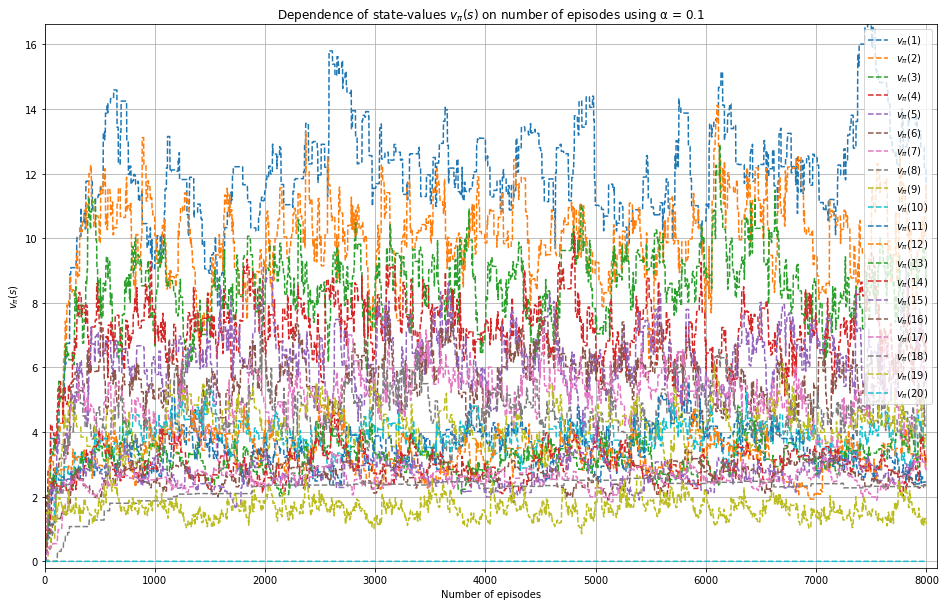

In [14]:
plot_td_zero(alpha=.1)

[13.336 10.95   9.203  7.336  6.958  6.136  5.31   4.687  4.526  4.021
  3.37   3.354  3.578  3.094  2.992  2.787  2.583  1.058  1.616  0.   ]


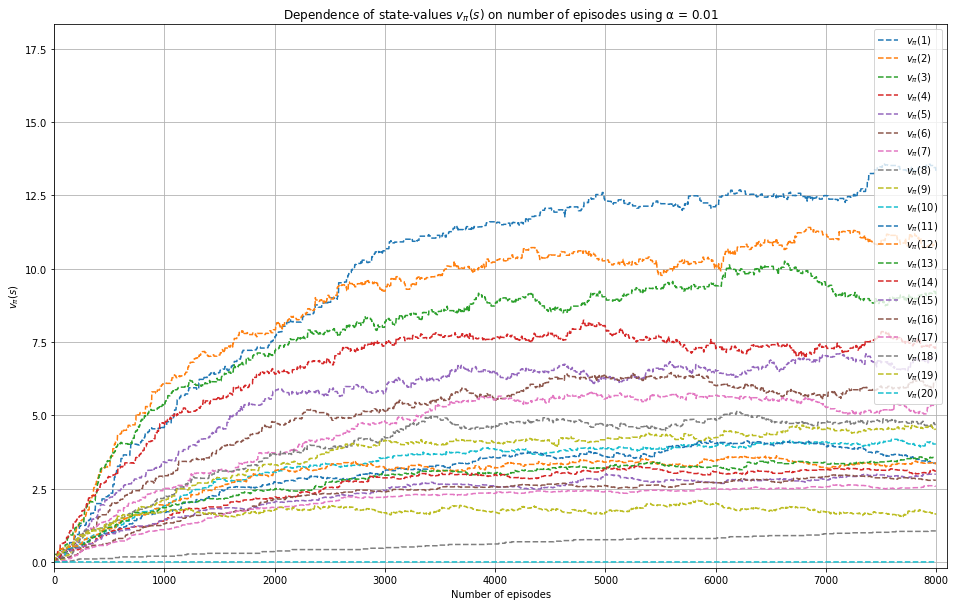

In [15]:
plot_td_zero(alpha=.01)

[4.16  4.72  4.559 3.831 3.337 2.742 2.483 2.143 1.989 1.688 1.527 1.491
 1.366 1.256 1.167 0.994 0.915 0.105 1.56  0.   ]


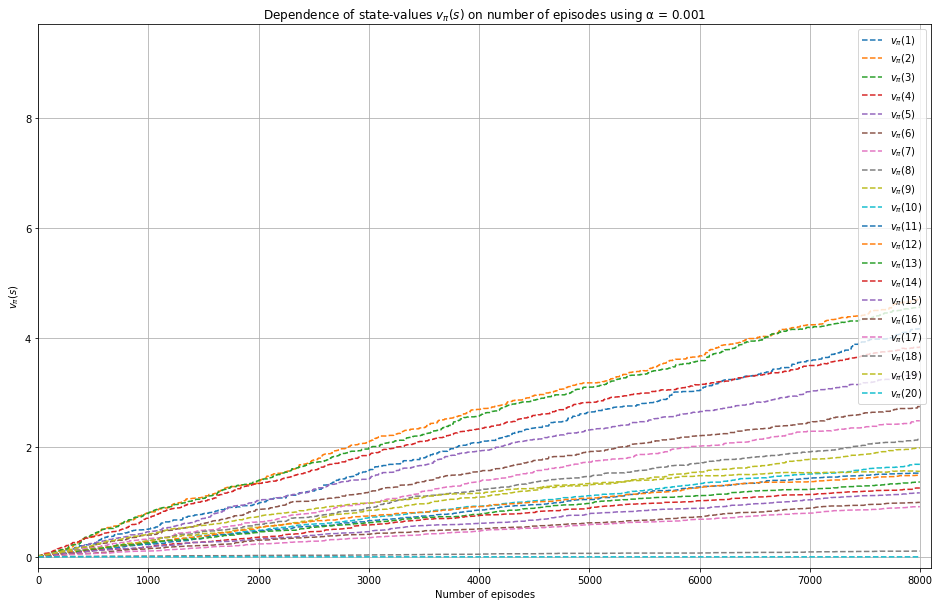

In [16]:
plot_td_zero(alpha=.001)

[13.538 10.934  9.218  7.269  6.994  6.18   5.304  4.656  4.526  4.004
  3.2    3.345  3.648  3.098  3.045  2.798  2.749  2.574  1.592  0.   ]


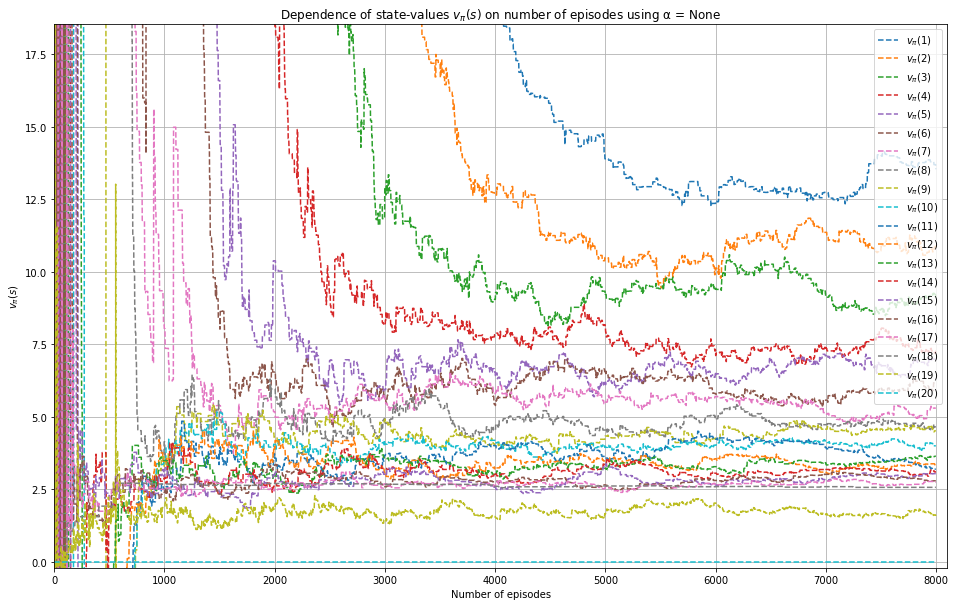

In [17]:
plot_td_zero(alpha=None)

We can see that $\alpha=.01$ gives good convergence. $\alpha=.1$ takes too large steps, wherease .001 takes too long to converge. A dynamic $\alpha$ of $\frac{1}{n}$ where n is the current index took step sizes that quickly became to small and got stuck. The plot above is dynamic step size of  $\frac{1}{n*1e-4}$ where we can see the large initial step sizes, followed by smaller step sizes to gradually converge, but it does so at a slower rate than the fixed $\alpha = .01$

## Part 1 checks

In [18]:
num_states = 3
# all are zero indexed
def v_hat(s, w):
    i = (s==2) *1
    return w[i]

def grad(s):
    return np.array([s!=2,s==2])*1

w = [i for i in range(num_states-1)]
for s in range(num_states):
    print("State",s,", V_hat:",v_hat(s, w),", gradients:", grad(s))
 

State 0 , V_hat: 0 , gradients: [1 0]
State 1 , V_hat: 0 , gradients: [1 0]
State 2 , V_hat: 1 , gradients: [0 1]


In [19]:
w = np.zeros(2)
v_hat(2,w)

0.0

In [20]:
gamma = .9
alpha = .1
states = [0,2,1,2,2,1]
actions = [2,1,2,2,1]
rewards = [20,0,20,20,0]

#sharing weights
w = np.zeros(2)

for t in range(5):
    s = states[t]
    s_ = states[t+1]
    r = rewards[t]

    w += alpha * (rewards[t] + gamma*v_hat(s_,w) - v_hat(s,w)) * grad(s)
    print(t+1,"="*12)
    print("W:",w)
    print("V_hat:",[round(v_hat(i,w),3) for i in range(3)])
    

    

1 ============
W: [2. 0.]
V_hat: [2.0, 2.0, 0.0]
2 ============
W: [2.   0.18]
V_hat: [2.0, 2.0, 0.18]
3 ============
W: [3.816 0.18 ]
V_hat: [3.816, 3.816, 0.18]
4 ============
W: [3.816 2.178]
V_hat: [3.816, 3.816, 2.178]
5 ============
W: [3.816 2.304]
V_hat: [3.816, 3.816, 2.304]
